In [2]:
#let's strat with bismillah

## **import libraries**

In [3]:
# libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
np.random.seed(32)


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.callbacks import EarlyStopping

%matplotlib inline

## **### The dataset**

In [4]:
data = pd.read_csv("arabic_categorization_data.csv")

In [5]:
data.head()

,Unnamed: 0,text,type
0,0,\nأشرف رئيس الجمهورية الباجي قايد السبسي اليوم...,culture
1,1,"\nتحصل كتاب ""المصحف وقراءاته"" الذي ألفه باحثون...",culture
2,2,\nاستنكرت إدارة المسرح الوطني التونسي الحملة ا...,culture
3,3,\nاحتضن جناح تونس في القرية الدولية للأفلام بم...,culture
4,4,\nشهدت برلين أمس الجمعة افتتاح مسجد فريد من نو...,culture


In [6]:
data.keys()

Index(['Unnamed: 0', 'text', 'type'], dtype='object')

In [7]:
data.type

0          culture
1          culture
2          culture
3          culture
4          culture
           ...    
10361    localnews
10362    localnews
10363    localnews
10364    localnews
10365    localnews
Name: type, Length: 10366, dtype: object

In [8]:
train_text, test_text, train_y, test_y = train_test_split(data['text'],data['type'],test_size = 0.2, random_state=2019)

## **Preprocessing text for the CBOW model**

In [9]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 90787 unique tokens.


In [10]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 90787)

In [11]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [12]:
" ".join([index_to_word[i] for i in sequences[0]])

'أدى وزير التربية، ناجي جلول مساء أمس الاثنين زيارة فجئية إلى المدرسة الإعدادية بالنفيضة وقد تحدّث الوزير مع عدد من التلاميذ عن ظروف الدراسة والإقامة بالمدرسة الإعدادية المذكورة، كما قام أيضا بزيارة المطعم أين عاين جملة من الإخلالات'

In [13]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 98.7
max length: 961


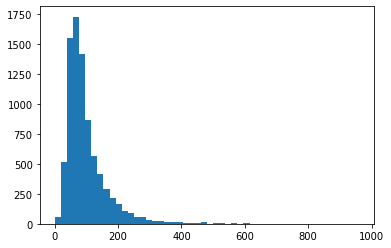

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

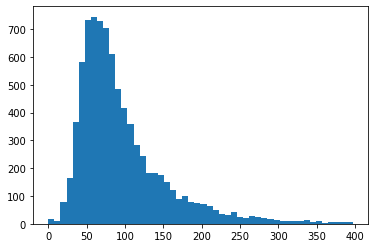

In [15]:
plt.hist([l for l in seq_lens if l < 400], bins=50);

In [16]:
# pad vectors to maximum length
MAX_SEQUENCE_LENGTH = 300

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (8292, 300)
Shape of data test tensor: (2074, 300)


In [17]:
# encode y data labels
encoder = LabelEncoder()
encoder.fit(train_y)
y_train = encoder.transform(train_y)
y_test = encoder.transform(test_y)

In [18]:
# Converts the labels to a one-hot representation
N_CLASSES = np.max(y_train) + 1
y_train = to_categorical(y_train, N_CLASSES)
y_test = to_categorical(y_test, N_CLASSES)
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (8292, 9)


In [19]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [22]:
model.fit(x_train, y_train, validation_split=0.2,
          epochs=40, batch_size=128, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/40
52/52 [==============================] - 2s 20ms/step - loss: 2.1476 - acc: 0.3347 - val_loss: 1.9824 - val_acc: 0.4653
Epoch 2/40
52/52 [==============================] - 1s 16ms/step - loss: 1.9171 - acc: 0.4673 - val_loss: 1.7252 - val_acc: 0.4647
Epoch 3/40
52/52 [==============================] - 1s 16ms/step - loss: 1.7103 - acc: 0.4521 - val_loss: 1.6229 - val_acc: 0.4647
Epoch 4/40
52/52 [==============================] - 1s 15ms/step - loss: 1.6071 - acc: 0.4701 - val_loss: 1.5830 - val_acc: 0.4665
Epoch 5/40
52/52 [==============================] - 1s 15ms/step - loss: 1.5883 - acc: 0.4685 - val_loss: 1.5472 - val_acc: 0.4684
Epoch 6/40
52/52 [==============================] - 1s 15ms/step - loss: 1.5306 - acc: 0.4714 - val_loss: 1.5089 - val_acc: 0.4744
Epoch 7/40
52/52 [==============================] - 1s 15ms/step - loss: 1.4907 - acc: 0.4759 - val_loss: 1.4680 - val_acc: 0.4846
Epoch 8/40
52/52 [==============================] - 1s 15ms/step - loss: 1.4333 - a

In [23]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test))

test auc: 0.9574300192033264


In [24]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

33/33 [==============================] - 0s 3ms/step - loss: 0.6439 - acc: 0.7734
Test loss: 0.6439371109008789
Test accuracy: 0.7733847498893738


In [25]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(50,80):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(texts_test.iloc[i], "...")
    print('Actual label:' + test_y.iloc[i])
    print("Predicted label: " + predicted_label + "\n")  


سلّم حسين العباسي، اليوم الجمعة مهام الأمانة العامة للاتحاد العام التونسي للشغل للأمين العام الجديد، نور الدين الطبوبي وذلك بحضور أعضاء المكتب التنفيذي الوطني وثلة من النقابيين.
 ...
Actual label:localnews
Predicted label: localnews


توج لاعب التونسي مالك الجزيري ببطولة إسطنبول التركية للتنس بعد فوزه في الدور النهائي على منافس من الكيان الصهيوني بنتيجة شوطين لشوط تفاصيلها 1-6 . 6-0 . 6 - 0 .
 ...
Actual label:sport
Predicted label: sport


تنظم الهيئة التنفيذية لتظاهرة صفاقس عاصمة للثقافة العربية 2016 مسابقة مفتوحة أمام الفنانين التشكيليين والنحاتين من تونس وكل البلدان العربية لتصميم وانجاز نصب تذكاري للتظاهرة حسب ما أكده مراسل الجوهرة "اف ام".
وتندرج هذه المسابقة في اطار حاجة مدينة صفاقس لنصب تذكاري يليق بها ويؤرخ لتألقها و تميزها ، وتتمثل شروط المشاركة في تكوين ملف تقني يتضمن المادة التي سيصنع منها النصب و نموذج له باعتماد تقنيات ثلاثية الأبعاد .  
 ...
Actual label:culture
Predicted label: localnews


قال كمال الزبع الكاتب العام لنقابة قوات الأمن فوج مدنين والمنسق الجهوي لنقابة قو

## **model : LSTM**

In [26]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.5, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [28]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=3, batch_size=64)

Epoch 1/3
117/117 [==============================] - 97s 804ms/step - loss: 1.0686 - acc: 0.6590 - val_loss: 1.1861 - val_acc: 0.7024
Epoch 2/3
117/117 [==============================] - 94s 800ms/step - loss: 0.4489 - acc: 0.8638 - val_loss: 0.6878 - val_acc: 0.7759
Epoch 3/3
117/117 [==============================] - 94s 801ms/step - loss: 0.4252 - acc: 0.8698 - val_loss: 0.7298 - val_acc: 0.7940


In [29]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test))

test auc: 0.9255229927089421


In [30]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

33/33 [==============================] - 4s 111ms/step - loss: 0.7961 - acc: 0.7734
Test loss: 0.7960547804832458
Test accuracy: 0.7733847498893738


## **model : CNN - LSTM**

In [31]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.3)(x)
x = LSTM(32)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [32]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=3, batch_size=128)

Epoch 1/3
59/59 [==============================] - 11s 145ms/step - loss: 1.3756 - acc: 0.5690 - val_loss: 0.7039 - val_acc: 0.7783
Epoch 2/3
59/59 [==============================] - 8s 136ms/step - loss: 0.4760 - acc: 0.8575 - val_loss: 0.6282 - val_acc: 0.7892
Epoch 3/3
59/59 [==============================] - 8s 137ms/step - loss: 0.3371 - acc: 0.8974 - val_loss: 0.6120 - val_acc: 0.7976


In [33]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

33/33 [==============================] - 1s 19ms/step - loss: 0.6827 - acc: 0.7792
Test loss: 0.6827487349510193
Test accuracy: 0.7791706919670105


In [34]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test))

test auc: 0.939903773771584


In [35]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(texts_test.iloc[i], "...")
    print('Actual label:' + test_y.iloc[i])
    print("Predicted label: " + predicted_label + "\n") 


قامت وحدات اقليم شرطة نابل بمداهمة مخزن عشوائي في ساعة متأخرة من ليلة أمس بعد الحصول على الأذون اللازمة من وكيل الجمهورية وتمكنت من حجز 120 قارورة غاز معدة للإستعمال المنزلي و130 قارورة غاز صغيرة الحجم وآلة لضخ البنزين .
وتم ايقاف صاحب المخزن العشوائي بجهة بني خيار و2 من مساعديه إذ تبين بعد التحقيق الأولي أن أحدهم مفتش عنه لدى مختلف الوحدات الأمنية بنابل. وقد تمت المداهمة وفق ما ذكرته مراسلة الجوهرة "اف ام" بالجهة اثر ورود معلومات بهذا الخصوص وتم ايقاف المتهمين وتحرير محضر في الغرض.
 ...
Actual label:localnews
Predicted label: localnews


تم مساء اليوم الثلاثاء، خلال جلسة عامة لمجلس نواب الشعب، التصويت بالرفض على مقترح مجموعة من النواب بإحداث لجنة تحقيق برلمانية للنظر في شبهة فساد مالي وإداري ضد رئيسة هيئة الحقيقة والكرامة، سهام بن سدرين.
وصوت 82 نائبا بنعم، واحتفظ نائبان بصوتهما في حين عارض هذا المقترح 80 نائبا، ليتم إسقاطه. وأوضح، عبد الفتاح مورو، نائب رئيس مجلس نواب الشعب، الذي ترأس الجلسة العامة بالبرلمان أن الفصل 97 من النظام الداخلي ينص على أن اللجان تكون بأغلبية الحضور، وبالتال